# 5.  Modeling 
##  (4) <span style = 'color:darkcyan'>딥러닝 모델(GRU, LSTM)</span>을 사용하여 6,7,8월 음식물 쓰레기 예측

1. 에측에 필요한 데이터 마련

    **시간적 데이터**: 각 행에 해당하는 월, 요일, 날짜 등 시간적인 데이터를 추가한다 \
		-> 시계열적인 특성을 살리기 위함

    **전년도 데이터**: 셀렉팅된 피쳐셋의 1년 전 데이터를 새로운 피쳐로 활용 \
		-> 1년 전 데이터를 통해 특정일에 대한 과적합을 방지하고 일반화하기 위함
 
    **함수의 파라미터 two**: 7월 예측, 8월 예측에 따라 필요한 target데이터를 처리해준다 \
 		-> 7월예측은 한달전 데이터로, 8월예측은 두달전 데이터가 필요하기 때문이다.
        
        
 2. lSTM,GRU 각각의 모델로 6개의 군집에 대해 6월 예측
 3. 에측 결과를 바탕으로 각 군집에서 성능이 좋은 모델로 7,8월 예측

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 6월 예측

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc 
%matplotlib inline
rc('font', family='malgun gothic')
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
import warnings

warnings.filterwarnings(action='ignore')

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score , silhouette_samples

import xgboost as xgb
import lightgbm as lgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.preprocessing.text import *
#from keras.utils import to_categorical
from tensorflow.keras.layers import InputLayer
from pandas.api.types import is_datetime64_any_dtype as is_datetime

In [ ]:
path= '/content/drive/MyDrive/빅콘테스트/data/'
df0=pd.read_csv(path + '군집0_feature_corona.csv')
df0=df0.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

df1=pd.read_csv(path + '군집1_feature_corona.csv')
df1=df1.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

df2=pd.read_csv(path + '군집2_feature_corona.csv')
df2=df2.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

df3=pd.read_csv(path + '군집3_feature_corona.csv')
df3=df3.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

df4=pd.read_csv(path + '군집4_feature_corona.csv')
df4=df4.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

df5=pd.read_csv(path + '군집5_feature_corona.csv')
df5=df5.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

df6=pd.read_csv(path + '군집6_feature_corona.csv')
df6=df6.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    
    df['date']=pd.to_datetime(df['base_date_jh'])
    #df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    #df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    #df['em_g_diff1'] = df['em_g_jh'].shift(31)
    yearfeature=df.iloc[:,3:].shift(365)
    yearfeature.columns=['year_'+i for i in df.iloc[:,3:].columns]
    
    df.iloc[:,3:] = df.iloc[:,3:].shift(31)
    df=df.query('base_date_jh>"2018-02-01"')
    df=pd.concat([df,yearfeature],axis=1).dropna(axis=0)
    
    dong=pd.get_dummies(df['emd_nm_jh'])
    df=pd.concat([df,dong],axis=1)
   # df=df.query('base_date>"2018-12-31"')
    #df=df.drop(['base_date','date','emd_nm'],axis=1)
    
    
    X = df
    
    if label:
        y = df[label]
        return X, y

# 군집 0

In [ ]:
X, y = create_features(df0, label='em_g_jh')

In [ ]:
X_train = X.query('base_date_jh<"2021-06-01"')
X_test = X.query('base_date_jh>="2021-06-01"')

### 3차원 변환

In [ ]:
y_train=y[X_train.index]
y_test=y[X_test.index]
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train)
y_train = pd.DataFrame(scaler.fit_transform(y_train,),columns= ['em_g_jh'] )
y_test = pd.DataFrame(scaler.fit_transform(y_test),columns= ['em_g_jh'] )

In [ ]:
X_train=X_train.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)
X_test=X_test.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)

In [ ]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)

(16662, 94)
[[-0.07936508 -0.3850385  -0.42       ...  0.          0.
   0.        ]
 [-0.14285714 -0.32893289 -0.3        ...  0.          0.
   0.        ]
 [ 0.03968254 -0.40044004 -0.36       ...  0.          0.
   0.        ]
 ...
 [-0.22222222 -0.33113311 -0.32       ...  0.          0.
   1.        ]
 [-0.18253968 -0.32123212 -0.31       ...  0.          0.
   1.        ]
 [ 0.22222222 -0.33553355 -0.31       ...  0.          0.
   1.        ]]
(16662, 1)
[[-0.53198023]
 [-0.03728228]
 [-0.41317595]
 ...
 [-0.8029845 ]
 [-0.63389473]
 [-0.60817619]]


In [ ]:
X_train_t = X_train.reshape(X_train.shape[0],X_train.shape[1],1 )
X_test_t = X_test.reshape(X_test.shape[0],X_train.shape[1],1 )

print("최종 DATA")
print(X_train_t.shape)
print(X_test_t.shape)
print(y_train.shape)
print(y_test.shape)

최종 DATA
(16662, 94, 1)
(408, 94, 1)
(16662, 1)
(408, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, X_test_t, y_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(X_test_t)

    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model, GRU_prediction = GRU_model(X_train_t, y_train, X_test_t, y_test)
 pred0 = scaler.inverse_transform(GRU_prediction)

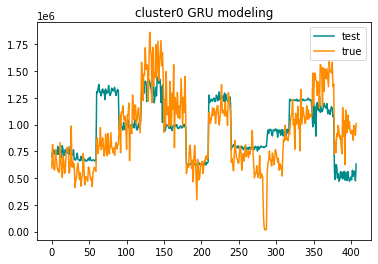

In [ ]:
pd.Series(pred0.reshape(408)).plot(color = 'darkcyan', label='test')

df0.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color = 'darkorange', label='true')
plt.title('cluster0 GRU modeling')
plt.legend()

### LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, X_test_t, y_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(X_test_t)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model0, LSTM_prediction0 = LSTM_model(X_train_t, y_train, X_test_t, y_test)
lpred0 = scaler.inverse_transform(LSTM_prediction0)

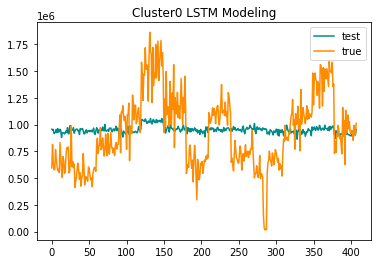

In [ ]:
pd.Series(lpred0.reshape(408)).plot(color ='darkcyan', label='test')
df0.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color = 'darkorange', label='true')
plt.title('Cluster0 LSTM Modeling')
plt.legend()

#1번군집

In [ ]:
X1, y1 = create_features(df1, label='em_g_jh')
X_train1 = X1.query('base_date_jh<"2021-06-01"')
X_test1 = X1.query('base_date_jh>="2021-06-01"')

In [ ]:
y_train1=y1[X_train1.index]
y_test1=y1[X_test1.index]

In [ ]:
y_train1 = y_train1.to_frame()
y_test1 = y_test1.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(y_train1)
y_train1 = pd.DataFrame(scaler.fit_transform(y_train1),columns= ['em_g_jh'] )
y_test1= pd.DataFrame(scaler.fit_transform(y_test1),columns= ['em_g_jh'] )

In [ ]:
X_train1=X_train1.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)
X_test1=X_test1.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)

In [ ]:
X_train1 = X_train1.values
X_test1= X_test1.values
X_train_t1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1],1 )
X_test_t1 = X_test1.reshape(X_test1.shape[0],X_train1.shape[1],1 )

print("최종 DATA")
print(X_train_t1.shape)
print(X_test_t1.shape)
print(y_train1.shape)
print(y_test1.shape)

최종 DATA
(2097, 56, 1)
(60, 56, 1)
(2097, 1)
(60, 1)


## GRU modeling

In [ ]:
def GRU_model(X_train_t, y_train, X_test_t, y_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(X_test_t)

    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model1, GRU_prediction1 = GRU_model(X_train_t1, y_train1, X_test_t1, y_test1)
 pred1 = scaler.inverse_transform(GRU_prediction1)

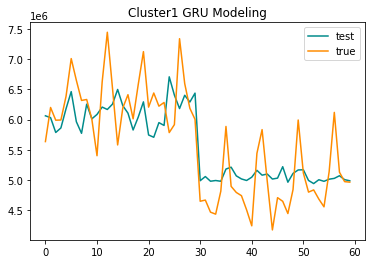

In [ ]:
pd.Series(pred1.reshape(60)).plot(color = 'darkcyan', label='test')

df1.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color = 'darkorange', label='true')
plt.title('Cluster1 GRU Modeling')
plt.legend()

### LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, X_test_t, y_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'relu'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'relu'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(X_test_t)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model1, LSTM_prediction1 = LSTM_model(X_train_t1, y_train1, X_test_t1, y_test1)
lpred1 = scaler.inverse_transform(LSTM_prediction1)

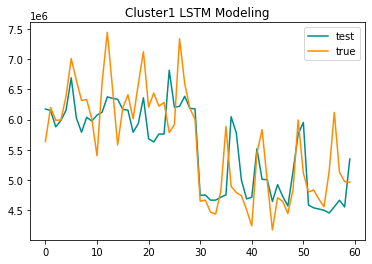

In [ ]:
pd.Series(lpred1.reshape(60)).plot(color= 'darkcyan', label='test')
df1.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color ='darkorange', label='true')
plt.title('Cluster1 LSTM Modeling')
plt.legend()

# 군집 2

In [ ]:
X2,y2 = create_features(df2, label='em_g_jh')
X_train2 = X2.query('base_date_jh<"2021-06-01"')
X_test2 = X2.query('base_date_jh>="2021-06-01"')

In [ ]:
y_train2=y2[X_train2.index]
y_test2=y2[X_test2.index]
y_train2 = y_train2.to_frame()
y_test2 = y_test2.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(y_train2)
y_train2 = pd.DataFrame(scaler.fit_transform(y_train2),columns= ['em_g_jh'] )
y_test2 = pd.DataFrame(scaler.fit_transform(y_test2),columns= ['em_g_jh'] )

In [ ]:
X_train2=X_train2.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)
X_test2=X_test2.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)

In [ ]:
X_train2 = X_train2.values
X_test2= X_test2.values
X_train_t2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1],1 )
X_test_t2 = X_test2.reshape(X_test2.shape[0],X_train2.shape[1],1 )

print("최종 DATA")
print(X_train_t2.shape)
print(X_test_t2.shape)
print(y_train2.shape)
print(y_test2.shape)

최종 DATA
(5741, 135, 1)
(150, 135, 1)
(5741, 1)
(150, 1)


## GRU modeling

In [ ]:
def GRU_model(X_train_t, y_train, X_test_t, y_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 50 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(X_test_t)
    #GRU_prediction = y_test.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction

In [ ]:
my_GRU_model2, GRU_prediction2 = GRU_model(X_train_t2, y_train2, X_test_t2, y_test2)
pred2 = scaler.inverse_transform(GRU_prediction2)

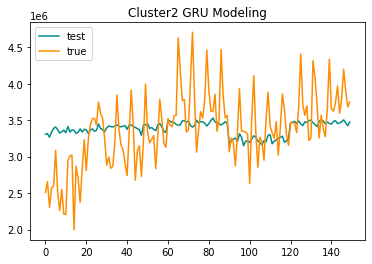

In [ ]:
pd.Series(pred2.reshape(150)).plot(color = 'darkcyan', label='test')

df2.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color = 'darkorange', label='true')
plt.title('Cluster2 GRU Modeling')
plt.legend()

### LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, X_test_t, y_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(X_test_t)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model2, LSTM_prediction2 = LSTM_model(X_train_t2, y_train2, X_test_t2, y_test2)
lpred2 = scaler.inverse_transform(LSTM_prediction2)

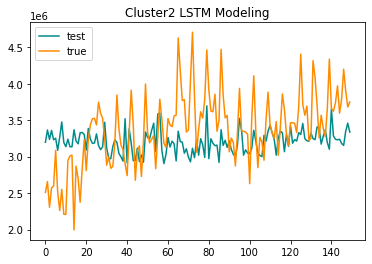

In [ ]:
pd.Series(lpred2.reshape(150)).plot(color= 'darkcyan', label='test')
df2.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color = 'darkorange', label='true')
plt.title('Cluster2 LSTM Modeling')
plt.legend()

# 군집 3

In [ ]:
X3,y3 = create_features(df3, label='em_g_jh')
X_train3 = X3.query('base_date_jh<"2021-06-01"')
X_test3 = X3.query('base_date_jh>="2021-06-01"')

In [ ]:
y_train3=y3[X_train3.index]
y_test3=y3[X_test3.index]
y_train3 = y_train3.to_frame()
y_test3 = y_test3.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(y_train3)
y_train3 = pd.DataFrame(scaler.fit_transform(y_train3),columns= ['em_g_jh'] )
y_test3 = pd.DataFrame(scaler.fit_transform(y_test3),columns= ['em_g_jh'] )

In [ ]:
X_train3=X_train3.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)
X_test3=X_test3.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)

In [ ]:
X_train3 = X_train3.values
X_test3= X_test3.values
X_train_t3 = X_train3.reshape(X_train3.shape[0],X_train3.shape[1],1 )
X_test_t3 = X_test3.reshape(X_test3.shape[0],X_train3.shape[1],1 )

print("최종 DATA")
print(X_train_t3.shape)
print(X_test_t3.shape)
print(y_train3.shape)
print(y_test3.shape)

최종 DATA
(14239, 162, 1)
(360, 162, 1)
(14239, 1)
(360, 1)


### GRU modeling

In [ ]:
def GRU_model(X_train_t, y_train, X_test_t, y_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(X_test_t)
  
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model3, GRU_prediction3 = GRU_model(X_train_t3, y_train3, X_test_t3, y_test3)
 pred3 = scaler.inverse_transform(GRU_prediction3)

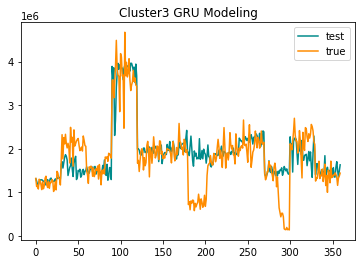

In [ ]:
pd.Series(pred3.reshape(360)).plot(color= 'darkcyan', label='test')

df3.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color = 'darkorange', label='true')
plt.title('Cluster3 GRU Modeling')
plt.legend()

### LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, X_test_t, y_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(X_test_t)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model3, LSTM_prediction3 = LSTM_model(X_train_t3, y_train3, X_test_t3, y_test3)
lpred3 = scaler.inverse_transform(LSTM_prediction3)

# 군집 4

In [ ]:
X4,y4 = create_features(df4, label='em_g_jh')
X_train4 = X4.query('base_date_jh<"2021-06-01"')
X_test4 = X4.query('base_date_jh>="2021-06-01"')

In [ ]:
y_train4=y4[X_train4.index]
y_test4=y4[X_test4.index]
y_train4 = y_train4.to_frame()
y_test4 = y_test4.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(y_train4)
y_train4 = pd.DataFrame(scaler.fit_transform(y_train4),columns= ['em_g_jh'] )
y_test4 = pd.DataFrame(scaler.fit_transform(y_test4),columns= ['em_g_jh'] )

In [ ]:
X_train4=X_train4.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)
X_test4=X_test4.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)

In [ ]:
X_train4 = X_train4.values
X_test4= X_test4.values
X_train_t4= X_train4.reshape(X_train4.shape[0],X_train4.shape[1],1 )
X_test_t4 = X_test4.reshape(X_test4.shape[0],X_train4.shape[1],1 )

print("최종 DATA")
print(X_train_t4.shape)
print(X_test_t4.shape)
print(y_train4.shape)
print(y_test4.shape)

최종 DATA
(2092, 38, 1)
(60, 38, 1)
(2092, 1)
(60, 1)


### GRU modeling

In [ ]:
def GRU_model(X_train_t, y_train, X_test_t, y_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs =100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(X_test_t)
 
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model4, GRU_prediction4 = GRU_model(X_train_t4, y_train4, X_test_t4, y_test4)
 pred4 = scaler.inverse_transform(GRU_prediction4)

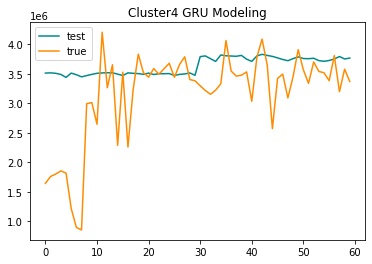

In [ ]:
pd.Series(pred4.reshape(60)).plot(color = 'darkcyan', label='test')

df4.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color = 'darkorange', label='true')
plt.title('Cluster4 GRU Modeling')
plt.legend()

### LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, X_test_t, y_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(X_test_t)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model4, LSTM_prediction4 = LSTM_model(X_train_t4, y_train4, X_test_t4, y_test4)
lpred4 = scaler.inverse_transform(LSTM_prediction4)

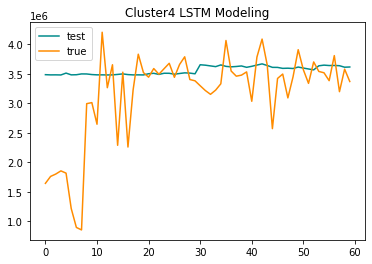

In [ ]:
pd.Series(lpred4.reshape(60)).plot(color = 'darkcyan', label='test')
df4.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color = 'darkorange', label='true')
plt.title('Cluster4 LSTM Modeling')
plt.legend()

# 군집 5

In [ ]:
X5,y5 = create_features(df5, label='em_g_jh')
X_train5 = X5.query('base_date_jh<"2021-06-01"')
X_test5 = X5.query('base_date_jh>="2021-06-01"')

In [ ]:
y_train5=y5[X_train5.index]
y_test5=y5[X_test5.index]
y_train5 = y_train5.to_frame()
y_test5 = y_test5.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(y_train5)
y_train5 = pd.DataFrame(scaler.fit_transform(y_train5),columns= ['em_g_jh'] )
y_test5 = pd.DataFrame(scaler.fit_transform(y_test5),columns= ['em_g_jh'] )

In [ ]:
X_train5=X_train5.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)
X_test5=X_test5.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)

In [ ]:
X_train5 = X_train5.values
X_test5= X_test5.values
X_train_t5= X_train5.reshape(X_train5.shape[0],X_train5.shape[1],1 )
X_test_t5 = X_test5.reshape(X_test5.shape[0],X_train5.shape[1],1 )

print("최종 DATA")
print(X_train_t5.shape)
print(X_test_t5.shape)
print(y_train5.shape)
print(y_test5.shape)

최종 DATA
(2097, 80, 1)
(60, 80, 1)
(2097, 1)
(60, 1)


### GRU modeling

In [ ]:
def GRU_model(X_train_t, y_train, X_test_t, y_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=10)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs =50, batch_size = 30 , verbose = 0
                     ,callbacks= es)
    
    GRU_prediction = my_GRU_model.predict(X_test_t)
    #GRU_prediction = y_test.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model5, GRU_prediction5 = GRU_model(X_train_t5, y_train5, X_test_t5, y_test5)
 pred5 = scaler.inverse_transform(GRU_prediction5)

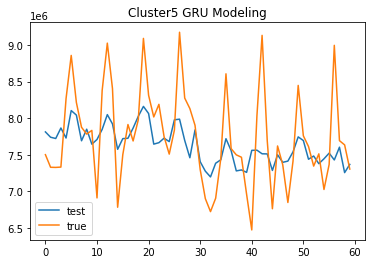

In [ ]:
pd.Series(pred5.reshape(60)).plot(label='test')

df5.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(label='true')
plt.title('Cluster5 GRU Modeling')
plt.legend()

### LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, X_test_t, y_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(X_test_t)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model5, LSTM_prediction5 = LSTM_model(X_train_t5, y_train5, X_test_t5, y_test5)
lpred5 = scaler.inverse_transform(LSTM_prediction5)

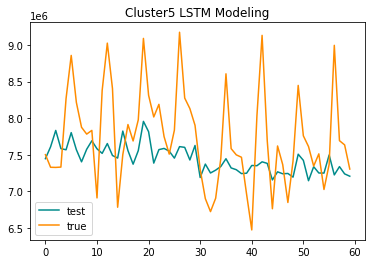

In [ ]:
pd.Series(lpred5.reshape(60)).plot(color = 'darkcyan', label='test')
df5.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color = 'darkorange', label='true')
plt.title('Cluster5 LSTM Modeling')
plt.legend()

# 군집 6

In [ ]:
X6,y6 = create_features(df6, label='em_g_jh')
X_train6 = X6.query('base_date_jh<"2021-06-01"')
X_test6 = X6.query('base_date_jh>="2021-06-01"')

In [ ]:
y_train6=y6[X_train6.index]
y_test6=y6[X_test6.index]
y_train6 = y_train6.to_frame()
y_test6 = y_test6.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(y_train6)
y_train6 = pd.DataFrame(scaler.fit_transform(y_train6),columns= ['em_g_jh'] )
y_test6 = pd.DataFrame(scaler.fit_transform(y_test6),columns= ['em_g_jh'] )

In [ ]:
X_train6=X_train6.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)
X_test6=X_test6.drop(['base_date_jh','date','emd_nm_jh','em_g_jh', 'year_date'],axis=1)

In [ ]:
X_train6 = X_train6.values
X_test6= X_test6.values
X_train_t6= X_train6.reshape(X_train6.shape[0],X_train6.shape[1],1 )
X_test_t6 = X_test6.reshape(X_test6.shape[0],X_train6.shape[1],1 )

print("최종 DATA")
print(X_train_t6.shape)
print(X_test_t6.shape)
print(y_train6.shape)
print(y_test6.shape)

최종 DATA
(2767, 75, 1)
(150, 75, 1)
(2767, 1)
(150, 1)


### GRU modeling

In [ ]:
def GRU_model(X_train_t, y_train, X_test_t, y_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=10)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs =200, batch_size = 30 , verbose = 0,
                     callbacks= es,)
    
    GRU_prediction = my_GRU_model.predict(X_test_t)
    #GRU_prediction = y_test.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model6, GRU_prediction6 = GRU_model(X_train_t6, y_train6, X_test_t6, y_test6)
 pred6 = scaler.inverse_transform(GRU_prediction6)

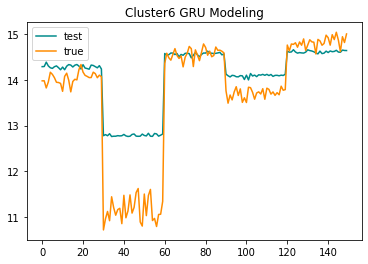

In [ ]:
pd.Series(pred6.reshape(150)).plot(color = 'darkcyan', label='test')

df6.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color= 'darkorange', label='true')
plt.title('Cluster6 GRU Modeling')
plt.legend()

### LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, X_test_t, y_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(X_test_t)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model6, LSTM_prediction6 = LSTM_model(X_train_t6, y_train6, X_test_t6, y_test6)
lpred6= scaler.inverse_transform(LSTM_prediction6)

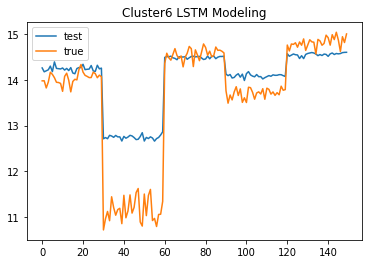

In [ ]:
pd.Series(lpred6.reshape(150)).plot(label='test')
df6.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(label='true')
plt.title('Cluster6 LSTM Modeling')
plt.legend()

In [ ]:
p0 = pd.DataFrame(pred0)
p1 = pd.DataFrame(pred1)
p2 = pd.DataFrame(pred2)
p3 = pd.DataFrame(pred3)
p4 = pd.DataFrame(pred4)
p5 = pd.DataFrame(pred5)
p6 = pd.DataFrame(pred6)

In [ ]:
g0 =list(pred0.reshape(408))
g1=list(pred1.reshape(60))
g2=list(pred2.reshape(150))
g3=list(pred3.reshape(360))
g4=list(pred4.reshape(60))
g5=list(pred5.reshape(60))
g6=list(pred6.reshape(150))

In [ ]:
gru_predict = {"c0":g0, "c1": g1, 'c2': g2, "c3":g3, "c4":g4, "c5":g5, "c6":g6}
gru_predict_all = pd.DataFrame.from_dict(gru_predict, orient='index').transpose()
gru_predict_all.to_csv('gru_predict_all.csv', index=False)

In [ ]:
p0.to_csv('gp0.csv', index=False)
p1.to_csv('gp1.csv', index=False)
p2.to_csv('gp2.csv', index=False)
p3.to_csv('gp3.csv', index=False)
p4.to_csv('gp4.csv', index=False)
p5.to_csv('gp5.csv', index=False)
p6.to_csv('gp6.csv', index=False)

In [ ]:
s0 =list(lpred0.reshape(408))
s1=list(lpred1.reshape(60))
s2=list(lpred2.reshape(150))
s3=list(lpred3.reshape(360))
s4=list(lpred4.reshape(60))
s5=list(lpred5.reshape(60))
s6=list(lpred6.reshape(150))

In [ ]:
LSTM_predict = {"c0":s0, "c1": s1, 'c2': s2,"c3": s3, "c4":s4, "c5":s5, "c6":s6}
LSTM_predict_all = pd.DataFrame.from_dict(LSTM_predict, orient='index').transpose()
LSTM_predict_all.to_csv('LSTM_predict_all.csv', index=False)

In [ ]:
LSTM_predict_all

,c0,c1,c2,c3,c4,c5,c6
0,956733.3125,6176404.0,3196945.75,1825531.875,3484021.25,7446781.5,14.263646
1,949809.8750,6150755.5,3365353.00,1826586.500,3480410.25,7608110.0,14.179199
2,955024.6250,5880102.5,3235904.50,1825528.875,3481053.25,7831975.0,14.201758
3,915922.1250,5985937.5,3359599.25,1825484.125,3479133.75,7584216.0,14.222763
4,921887.8125,6156944.0,3230908.50,1826729.375,3510685.00,7567800.5,14.303360
...,...,...,...,...,...,...,...
403,879600.6875,NaN,NaN,NaN,NaN,NaN,NaN
404,905525.5625,NaN,NaN,NaN,NaN,NaN,NaN
405,912010.0625,NaN,NaN,NaN,NaN,NaN,NaN
406,907083.0000,NaN,NaN,NaN,NaN,NaN,NaN


# 군집 별 모델 선택 (GRU, LSTM, 또는 두 모델 앙상블)
: predict값과 True값을 그린 그래프를 확인하며 실제값과 차이가 적은 모델을 선택

## 0:GRU
## 1:LSTM
## 2:LSTM
## 3:GRU
## 4:GRU
## 5:GRU
## 6: 두 모델 앙상블

In [ ]:
#6번 군집에 대한 GRU, LSTM 기하평균
gm6 = (pd.DataFrame(pred6) * pd.DataFrame(lpred6))**(1/2)
gm6_list = list(np.array(gm6[0].tolist()))

## 6월 최종 모델

In [ ]:
# 군집별 딥러닝 계열 모델 최종 선택
deep_predict = {"d0":g0, "d1": s1, 'd2': s2, "d3": g3, "d4":g4, "d5":g5, "d6":gm6_list}
deep_predict = pd.DataFrame.from_dict(deep_predict, orient='index').transpose()
deep_predict.to_csv('deep_06_predict.csv', index=False)

# 7월 데이터 예측

## 예측용 피쳐셋 생성

**전년도 데이터**: 셀렉팅된 피쳐셋의 1년 전 데이터를 새로운 피쳐로 활용 
		-> 1년 전 데이터를 통해 특정일에 대한 과적합을 방지하고 일반화하기 위함
 
 **시간적 데이터**: Rnn 계열의 모델은 각 열의 scale에 큰 영향을 받기 때문에 머신러닝 모델과 달리 시간적인 데이터는 추가하지 않았다

In [ ]:
def create_features(df, two,label=None):
    """
    Creates time series features from datetime index
    """
    
    d=[str(i).split(' ')[0] for i in pd.date_range('2021-07-01','2021-08-31',freq='D')]
    do=list(df['emd_nm_jh'].unique())
    da=d*len(do)
    don=[]
    for i in df['emd_nm_jh'].unique():
        don.extend(((i+',')*62).split(',')[:-1])
    tt=pd.DataFrame({'base_date_jh':da,'emd_nm_jh':don})

    df=pd.merge(tt,df, on=['base_date_jh','emd_nm_jh'],how='outer')
    df=df.sort_values(by=['emd_nm_jh','base_date_jh']).reset_index(drop=True)
    df_date=list(df['base_date_jh'])
    df_date.extend(d)
    df['base_date_jh']
    df['date']=pd.to_datetime(df['base_date_jh'])
    #df['em_g_diff1'] = df['em_g_jh'].shift(31)
    yearfeature=df.iloc[:,2:].shift(365) #전년도 피쳐
    yearfeature.columns=['year_'+i for i in df.iloc[:,2:].columns]
    
    if two==0:
        df.iloc[:,3:] = df.iloc[:,3:].shift(31) #7월 예측에 필요
    else: 
        df.iloc[:,3:] = df.iloc[:,3:].shift(62) #8월 예측에 필요

    df['shif']=df['em_g_jh'].shift(365) #1년 전의 y값
    df['target']=df['em_g_jh']-df['shif'] #현재값과 1년전의 차이
    df=pd.concat([df,yearfeature],axis=1)
    df=df.query('base_date_jh>"2018-12-31"')
    
    dong=pd.get_dummies(df['emd_nm_jh'])
    df=pd.concat([df,dong],axis=1)
   # df=df.query('base_date>"2018-12-31"')
    #df=df.drop(['base_date','date','emd_nm'],axis=1)
    
    
    X = df
    
    if label:
        y = df[label]
        return X, y
    else:
        return X

In [ ]:
#train, test 데이터 구축
def train_test2 (X,y):
    X_train = X.query('base_date_jh<"2021-06-01"')
    X_test = X.query('base_date_jh>="2021-06-01" & base_date_jh<="2021-06-30"')
    july = X.query('base_date_jh>="2021-07-01" & base_date_jh<="2021-07-31"')
    august = X.query('base_date_jh>="2021-08-01" & base_date_jh<="2021-08-31"')
    y_train=y[X_train.index]
    y_test=y[X_test.index]
    
    X_train.reset_index(drop=True)
    X_test.reset_index(drop=True)
    july.reset_index(drop=True)
    august.reset_index(drop=True)
    y_train.reset_index(drop=True)
    y_test.reset_index(drop=True)
    
    X_train=X_train.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    X_test=X_test.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    july=july.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    august=august.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    X=X.drop(['base_date_jh','date','emd_nm_jh','em_g_jh'],axis=1)
    
    return X,X_train,X_test,july,august,y_train,y_test

## 군집 0

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X, y = create_features(df0,0,'em_g_jh')

In [ ]:
X0,X_train0,X_test0,july0,august0,y_train0,y_test0=train_test2(X,y)

In [ ]:
print(X0.shape)
print(X_train0.shape)
print(X_test0.shape)
print(july0.shape)
print(august0.shape)
print(y_train0.shape)
print(y_test0.shape)

(13609, 98)
(12333, 95)
(408, 95)
(434, 95)
(434, 95)
(12333,)
(408,)


In [ ]:
y_train0 = y_train0.to_frame()
y_test0 = y_test0.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train0)
y_train0 = pd.DataFrame(scaler.fit_transform(y_train0,),columns= ['em_g_jh'] )
#y_test0 = pd.DataFrame(scaler.fit_transform(y_test0),columns= ['em_g_jh'] )

In [ ]:
X_train0 = X_train0.values
july0= july0.values

In [ ]:
X_train_t0 = X_train0.reshape(X_train0.shape[0],X_train0.shape[1],1 )
july0 = july0.reshape(july0.shape[0],july0.shape[1],1 )

print("최종 DATA")
print(X_train_t0.shape)
print(july0.shape)
print(y_train0.shape)
print(y_test0.shape)

최종 DATA
(12333, 95, 1)
(434, 95, 1)
(12333, 1)
(408, 1)


In [ ]:
july0.shape

(434, 95, 1)

## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model, GRU_prediction = GRU_model(X_train_t0, y_train0, july0)
 submit_pred0 = scaler.inverse_transform(GRU_prediction)

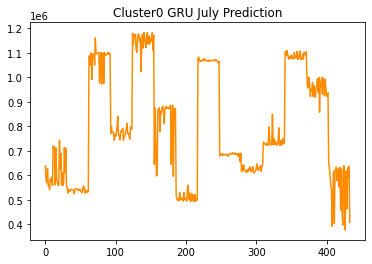

In [ ]:
plt.title('Cluster0 GRU July Prediction')
pd.Series(submit_pred0.reshape(434)).plot(color = 'darkorange', label='test')

## 군집 1

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X1, y1 = create_features(df1,0,'em_g_jh')

In [ ]:
X1,X_train1,X_test1,july1,august1,y_train1,y_test1=train_test2(X1,y1)

In [ ]:
y_train1 = y_train1.to_frame()
y_test1 = y_test1.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train1)
y_train1 = pd.DataFrame(scaler.fit_transform(y_train1,),columns= ['em_g_jh'] )

In [ ]:
X_train1 = X_train1.values
july1= july1.values

In [ ]:
X_train_t1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1],1 )
july1 = july1.reshape(july1.shape[0],july1.shape[1],1 )

print("최종 DATA")
print(X_train_t1.shape)
print(july1.shape)
print(y_train1.shape)
print(y_test1.shape)

최종 DATA
(1764, 57, 1)
(62, 57, 1)
(1764, 1)
(60, 1)


## LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, submit_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(submit_test)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model1, LSTM_prediction1 = LSTM_model(X_train_t1, y_train1, july1)
submit_pred1= scaler.inverse_transform(LSTM_prediction1)

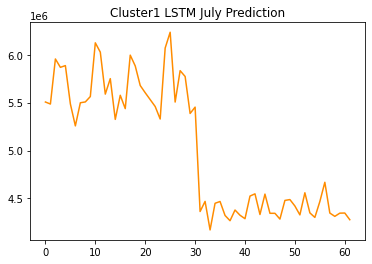

In [ ]:
plt.title('Cluster1 LSTM July Prediction')
pd.Series(submit_pred1.reshape(62)).plot(color = 'darkorange', label='test')

## 군집 2

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X2, y2 = create_features(df2,0,'em_g_jh')

In [ ]:
X2,X_train2,X_test2,july2,august2,y_train2,y_test2=train_test2(X2,y2)

In [ ]:
y_train2 = y_train2.to_frame()
y_test2 = y_test2.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train2)
y_train2 = pd.DataFrame(scaler.fit_transform(y_train2,),columns= ['em_g_jh'] )

In [ ]:
X_train2 = X_train2.values
july2= july2.values

In [ ]:
X_train_t2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1],1 )
july2 = july2.reshape(july2.shape[0],july2.shape[1],1 )

print("최종 DATA")
print(X_train_t2.shape)
print(july2.shape)
print(y_train2.shape)
print(y_test2.shape)

최종 DATA
(4409, 136, 1)
(155, 136, 1)
(4409, 1)
(150, 1)


## LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, submit_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(submit_test)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model2, LSTM_prediction2 = LSTM_model(X_train_t2, y_train2, july2)
submit_pred2= scaler.inverse_transform(LSTM_prediction2)

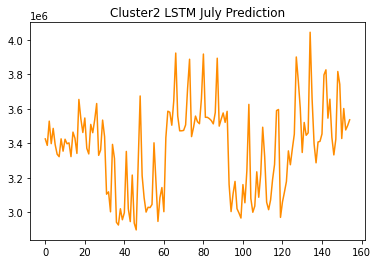

In [ ]:
plt.title('Cluster2 LSTM July Prediction')
pd.Series(submit_pred2.reshape(155)).plot(color = 'darkorange', label='test')

## 군집 3

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X3, y3 = create_features(df3,0,'em_g_jh')

In [ ]:
X3,X_train3,X_test3,july3,august3,y_train3,y_test3=train_test2(X3,y3)

In [ ]:
y_train3 = y_train3.to_frame()
y_test3 = y_test3.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train3)
y_train3 = pd.DataFrame(scaler.fit_transform(y_train3,),columns= ['em_g_jh'] )

In [ ]:
X_train3 = X_train3.values
july3= july3.values

In [ ]:
X_train_t3 = X_train3.reshape(X_train3.shape[0],X_train3.shape[1],1 )
july3 = july3.reshape(july3.shape[0],july3.shape[1],1 )

print("최종 DATA")
print(X_train_t3.shape)
print(july3.shape)
print(y_train3.shape)
print(y_test3.shape)

최종 DATA
(10576, 163, 1)
(372, 163, 1)
(10576, 1)
(360, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model3, GRU_prediction3 = GRU_model(X_train_t3, y_train3, july3)
 submit_pred3 = scaler.inverse_transform(GRU_prediction3)

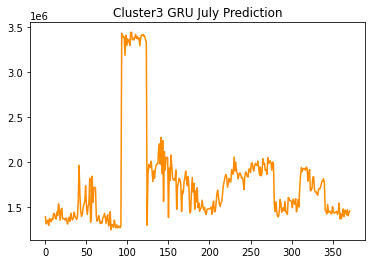

In [ ]:
plt.title('Cluster3 GRU July Prediction')
pd.Series(submit_pred3.reshape(372)).plot(color = 'darkorange', label='test')

## 군집 4

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X4, y4 = create_features(df4,0,'em_g_jh')

In [ ]:
X4,X_train4,X_test4,july4,august4,y_train4,y_test4=train_test2(X4,y4)

In [ ]:
y_train4 = y_train4.to_frame()
y_test4= y_test4.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train4)
y_train4 = pd.DataFrame(scaler.fit_transform(y_train4,),columns= ['em_g_jh'] )

In [ ]:
X_train4 = X_train4.values
july4= july4.values

In [ ]:
X_train_t4 = X_train4.reshape(X_train4.shape[0],X_train4.shape[1],1 )
july4 = july4.reshape(july4.shape[0],july4.shape[1],1 )

print("최종 DATA")
print(X_train_t4.shape)
print(july4.shape)
print(y_train4.shape)
print(y_test4.shape)

최종 DATA
(1759, 39, 1)
(62, 39, 1)
(1759, 1)
(60, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model4, GRU_prediction4 = GRU_model(X_train_t4, y_train4, july4)
 submit_pred4 = scaler.inverse_transform(GRU_prediction4)

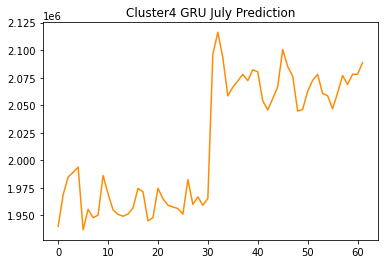

In [ ]:
plt.title('Cluster4 GRU July Prediction')
pd.Series(submit_pred4.reshape(62)).plot(color = 'darkorange', label='test')

## 군집 5

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X5, y5 = create_features(df5,0,'em_g_jh')

In [ ]:
X5,X_train5,X_test5,july5,august5,y_train5,y_test5=train_test2(X5,y5)

In [ ]:
y_train5 = y_train5.to_frame()
y_test5= y_test5.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train5)
y_train5 = pd.DataFrame(scaler.fit_transform(y_train5,),columns= ['em_g_jh'] )

In [ ]:
X_train5 = X_train5.values
july5= july5.values

In [ ]:
X_train_t5 = X_train5.reshape(X_train5.shape[0],X_train5.shape[1],1 )
july5 = july5.reshape(july5.shape[0],july5.shape[1],1 )

print("최종 DATA")
print(X_train_t5.shape)
print(july5.shape)
print(y_train5.shape)
print(y_test5.shape)

최종 DATA
(1764, 81, 1)
(62, 81, 1)
(1764, 1)
(60, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model5, GRU_prediction5 = GRU_model(X_train_t5, y_train5, july5)
 submit_pred5 = scaler.inverse_transform(GRU_prediction5)

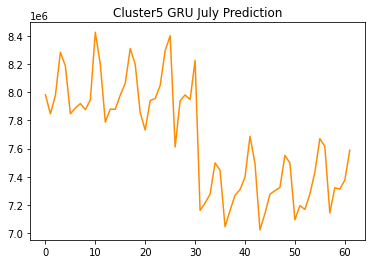

In [ ]:
plt.title('Cluster5 GRU July Prediction')
pd.Series(submit_pred5.reshape(62)).plot(color = 'darkorange', label='test')

## 군집 6

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X6, y6 = create_features(df6,0,'em_g_jh')

In [ ]:
X6,X_train6,X_test6,july6,august6,y_train6,y_test6=train_test2(X6,y6)

In [ ]:
X_train6.dropna(axis= 0).index

Int64Index([ 396,  397,  398,  399,  400,  401,  402,  403,  404,  405,
            ...
            3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531],
           dtype='int64', length=2124)

In [ ]:
y_train6 = y_train6[X_train6.dropna(axis= 0).index]
X_train6 = X_train6.dropna(axis= 0)

In [ ]:
y_train6 = y_train6.to_frame()
y_test6= y_test6.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train6)
y_train6 = pd.DataFrame(scaler.fit_transform(y_train6),columns= ['em_g_jh'] )

In [ ]:
X_train6 = X_train6.values
july6= july6.values

In [ ]:
X_train6

array([[-0.26984127, -0.54      , -0.24386443, ...,  0.        ,
         0.        ,  0.        ],
       [-0.22222222, -0.54      , -0.19162696, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13492063, -0.53      , -0.14496077, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.3015873 , -0.49      ,  0.39805095, ...,  0.        ,
         0.        ,  1.        ],
       [-0.24603175, -0.43      ,  0.45639712, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25396825, -0.41      ,  0.59082441, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
X_train_t6 = X_train6.reshape(X_train6.shape[0],X_train6.shape[1],1 )
july6 = july6.reshape(july6.shape[0],july6.shape[1],1 )

print("최종 DATA")
print(X_train_t6.shape)
print(july6.shape)
print(y_train6.shape)
print(y_test6.shape)

최종 DATA
(2124, 76, 1)
(155, 76, 1)
(2124, 1)
(150, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model6, GRU_prediction6 = GRU_model(X_train_t6, y_train6, july6)
 submit_pred6 = scaler.inverse_transform(GRU_prediction6)

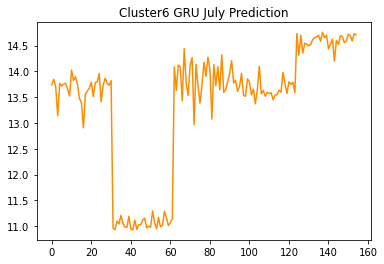

In [ ]:
plt.title('Cluster6 GRU July Prediction')
pd.Series(submit_pred6.reshape(155)).plot(color = 'darkorange', label='test')

In [ ]:
my_GRU_model6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 76, 50)            7950      
_________________________________________________________________
gru_7 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


## LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, submit_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(submit_test)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model6, LSTM_prediction6 = LSTM_model(X_train_t6, y_train6, july6)
lstm_submit_pred6= scaler.inverse_transform(LSTM_prediction6)

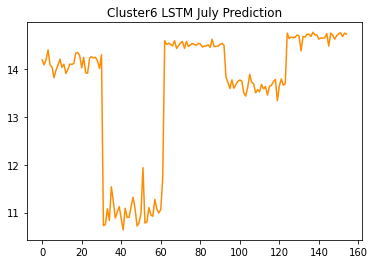

In [ ]:
plt.title('Cluster6 LSTM July Prediction')
pd.Series(lstm_submit_pred6.reshape(155)).plot(color = 'darkorange', label='test')

In [ ]:
my_LSTM_model6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 76, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#6번 군집에 대한 GRU, LSTM 기하평균
julygm6 = (pd.DataFrame(submit_pred6) * pd.DataFrame(lstm_submit_pred6))**(1/2)
julygm6_list = list(np.array(julygm6[0].tolist()))

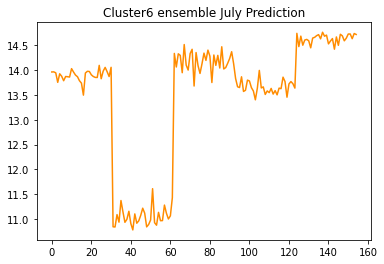

In [ ]:
plt.title('Cluster6 ensemble July Prediction')
plt.plot(julygm6, color = 'darkorange', label='test')

## 7월 최종 예측

In [ ]:
g0 =list(submit_pred0.reshape(434))
g1=list(submit_pred1.reshape(62))
g2=list(submit_pred2.reshape(155))
g3=list(submit_pred3.reshape(372))
g4=list(submit_pred4.reshape(62))
g5=list(submit_pred5.reshape(62))
g6=julygm6_list

In [ ]:
july_predict = {"d0":g0, "d1": g1, 'd2': g2, "d3":g3, "d4":g4, "d5":g5, "d6"; g6}
july_predict_all = pd.DataFrame.from_dict(july_predict, orient='index').transpose()
july_predict_all.to_csv('deep_07_predict.csv', index=False)

## 8월 예측하기

## 군집 0

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X, y = create_features(df0,1,'em_g_jh')

In [ ]:
X0,X_train0,X_test0,july0,august0,y_train0,y_test0=train_test2(X,y)

In [ ]:
print(X0.shape)
print(X_train0.shape)
print(X_test0.shape)
print(july0.shape)
print(august0.shape)
print(y_train0.shape)
print(y_test0.shape)

(13609, 98)
(12333, 95)
(408, 95)
(434, 95)
(434, 95)
(12333,)
(408,)


In [ ]:
y_train0 = y_train0.to_frame()
y_test0 = y_test0.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train0)
y_train0 = pd.DataFrame(scaler.fit_transform(y_train0,),columns= ['em_g_jh'] )
#y_test0 = pd.DataFrame(scaler.fit_transform(y_test0),columns= ['em_g_jh'] )

In [ ]:
X_train0 = X_train0.values
august0= august0.values

In [ ]:
X_train_t0 = X_train0.reshape(X_train0.shape[0],X_train0.shape[1],1 )
august0 = august0.reshape(august0.shape[0],august0.shape[1],1 )

print("최종 DATA")
print(X_train_t0.shape)
print(august0.shape)
print(y_train0.shape)
print(y_test0.shape)

최종 DATA
(12333, 95, 1)
(434, 95, 1)
(12333, 1)
(408, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model, GRU_prediction = GRU_model(X_train_t0, y_train0, august0)
 submit_pred0 = scaler.inverse_transform(GRU_prediction)

findfont: Font family ['malgun gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['malgun gothic'] not found. Falling back to DejaVu Sans.


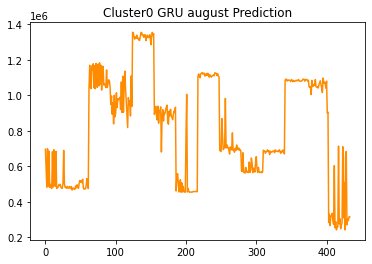

In [ ]:
plt.title('Cluster0 GRU august Prediction')
pd.Series(submit_pred0.reshape(434)).plot(color = 'darkorange', label='test')

## 군집 1

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X1, y1 = create_features(df1,1,'em_g_jh')

In [ ]:
X1,X_train1,X_test1,july1,august1,y_train1,y_test1=train_test2(X1,y1)

In [ ]:
y_train1 = y_train1.to_frame()
y_test1 = y_test1.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train1)
y_train1 = pd.DataFrame(scaler.fit_transform(y_train1,),columns= ['em_g_jh'] )

In [ ]:
X_train1 = X_train1.values
august1= august1.values

In [ ]:
X_train_t1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1],1 )
august1 = august1.reshape(august1.shape[0],august1.shape[1],1 )

print("최종 DATA")
print(X_train_t1.shape)
print(august1.shape)
print(y_train1.shape)
print(y_test1.shape)

최종 DATA
(1764, 57, 1)
(62, 57, 1)
(1764, 1)
(60, 1)


## LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, submit_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(submit_test)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model1, LSTM_prediction1 = LSTM_model(X_train_t1, y_train1, august1)
submit_pred1= scaler.inverse_transform(LSTM_prediction1)

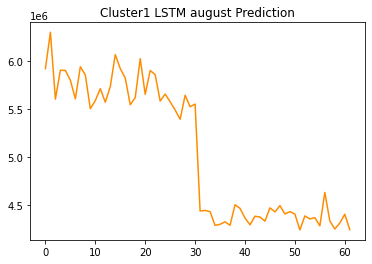

In [ ]:
plt.title('Cluster1 LSTM august Prediction')
pd.Series(submit_pred1.reshape(62)).plot(color = 'darkorange', label='test')

## 군집 2

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X2, y2 = create_features(df2,1,'em_g_jh')

In [ ]:
X2,X_train2,X_test2,july2,august2,y_train2,y_test2=train_test2(X2,y2)

In [ ]:
y_train2 = y_train2.to_frame()
y_test2 = y_test2.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train2)
y_train2 = pd.DataFrame(scaler.fit_transform(y_train2),columns= ['em_g_jh'] )

In [ ]:
X_train2 = X_train2.values
august2= august2.values

In [ ]:
X_train_t2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1],1 )
august2 = august2.reshape(august2.shape[0],august2.shape[1],1 )

print("최종 DATA")
print(X_train_t2.shape)
print(august2.shape)
print(y_train2.shape)
print(y_test2.shape)

최종 DATA
(4409, 136, 1)
(155, 136, 1)
(4409, 1)
(150, 1)


## LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, submit_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(submit_test)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model2, LSTM_prediction2 = LSTM_model(X_train_t2, y_train2, august2)
submit_pred2= scaler.inverse_transform(LSTM_prediction2)

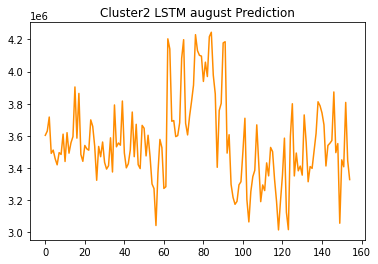

In [ ]:
plt.title('Cluster2 LSTM august Prediction')
pd.Series(submit_pred2.reshape(155)).plot(color = 'darkorange', label='test')

## 군집 3

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X3, y3 = create_features(df3,1,'em_g_jh')

In [ ]:
X3,X_train3,X_test3,july3,august3,y_train3,y_test3=train_test2(X3,y3)

In [ ]:
y_train3 = y_train3.to_frame()
y_test3 = y_test3.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train3)
y_train3 = pd.DataFrame(scaler.fit_transform(y_train3,),columns= ['em_g_jh'] )

In [ ]:
X_train3 = X_train3.values
august3= august3.values

In [ ]:
X_train_t3 = X_train3.reshape(X_train3.shape[0],X_train3.shape[1],1 )
august3 = august3.reshape(august3.shape[0],august3.shape[1],1 )

print("최종 DATA")
print(X_train_t3.shape)
print(august3.shape)
print(y_train3.shape)
print(y_test3.shape)

최종 DATA
(10576, 163, 1)
(372, 163, 1)
(10576, 1)
(360, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model3, GRU_prediction3 = GRU_model(X_train_t3, y_train3, august3)
 submit_pred3 = scaler.inverse_transform(GRU_prediction3)

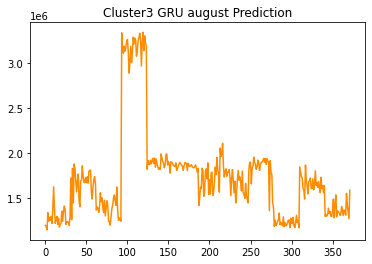

In [ ]:
plt.title('Cluster3 GRU august Prediction')
pd.Series(submit_pred3.reshape(372)).plot(color = 'darkorange', label='test')

## 군집 4

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X4, y4 = create_features(df4,1,'em_g_jh')

In [ ]:
X4,X_train4,X_test4,july4,august4,y_train4,y_test4=train_test2(X4,y4)

In [ ]:
y_train4 = y_train4.to_frame()
y_test4= y_test4.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train4)
y_train4 = pd.DataFrame(scaler.fit_transform(y_train4,),columns= ['em_g_jh'] )

In [ ]:
X_train4 = X_train4.values
august4= august4.values

In [ ]:
X_train_t4 = X_train4.reshape(X_train4.shape[0],X_train4.shape[1],1 )
august4 = august4.reshape(august4.shape[0],august4.shape[1],1 )

print("최종 DATA")
print(X_train_t4.shape)
print(august4.shape)
print(y_train4.shape)
print(y_test4.shape)

최종 DATA
(1759, 39, 1)
(62, 39, 1)
(1759, 1)
(60, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model4, GRU_prediction4 = GRU_model(X_train_t4, y_train4, august4)
 submit_pred4 = scaler.inverse_transform(GRU_prediction4)

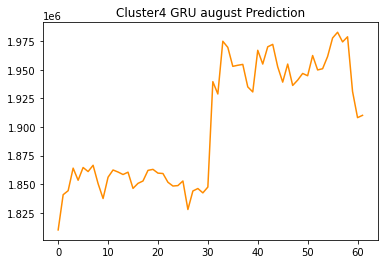

In [ ]:
plt.title('Cluster4 GRU august Prediction')
pd.Series(submit_pred4.reshape(62)).plot(color = 'darkorange', label='test')

## 군집 5

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X5, y5 = create_features(df5,1,'em_g_jh')

In [ ]:
X5,X_train5,X_test5,july5,august5,y_train5,y_test5=train_test2(X5,y5)

In [ ]:
y_train5 = y_train5.to_frame()
y_test5= y_test5.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train5)
y_train5 = pd.DataFrame(scaler.fit_transform(y_train5,),columns= ['em_g_jh'] )

In [ ]:
X_train5 = X_train5.values
august5= august5.values

In [ ]:
X_train_t5 = X_train5.reshape(X_train5.shape[0],X_train5.shape[1],1 )
august5 = august5.reshape(august5.shape[0],august5.shape[1],1 )

print("최종 DATA")
print(X_train_t5.shape)
print(august5.shape)
print(y_train5.shape)
print(y_test5.shape)

최종 DATA
(1764, 81, 1)
(62, 81, 1)
(1764, 1)
(60, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model5, GRU_prediction5 = GRU_model(X_train_t5, y_train5, august5)
 submit_pred5 = scaler.inverse_transform(GRU_prediction5)

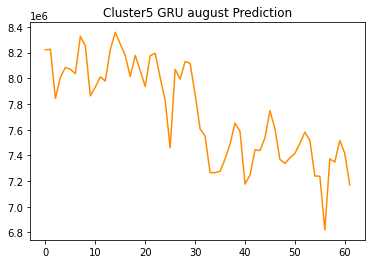

In [ ]:
plt.title('Cluster5 GRU august Prediction')
pd.Series(submit_pred5.reshape(62)).plot(color = 'darkorange', label='test')

## 군집 6

#### 데이터 스케일링 및 3차원 변형

In [ ]:
X6, y6 = create_features(df6,1,'em_g_jh')

In [ ]:
X6,X_train6,X_test6,july6,august6,y_train6,y_test6=train_test2(X6,y6)

In [ ]:
X_train6.dropna(axis= 0).index

Int64Index([ 365,  366,  367,  368,  369,  370,  371,  372,  373,  374,
            ...
            3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531],
           dtype='int64', length=2062)

In [ ]:
y_train6 = y_train6[X_train6.dropna(axis= 0).index]
X_train6 = X_train6.dropna(axis= 0)

In [ ]:
y_train6 = y_train6.to_frame()
y_test6= y_test6.to_frame()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(y_train6)
y_train6 = pd.DataFrame(scaler.fit_transform(y_train6),columns= ['em_g_jh'] )

In [ ]:
X_train6 = X_train6.values
august6= august6.values

In [ ]:
X_train_t6 = X_train6.reshape(X_train6.shape[0],X_train6.shape[1],1 )
august6 = august6.reshape(august6.shape[0],august6.shape[1],1 )

print("최종 DATA")
print(X_train_t6.shape)
print(august6.shape)
print(y_train6.shape)
print(y_test6.shape)

최종 DATA
(2062, 76, 1)
(155, 76, 1)
(2062, 1)
(150, 1)


## Gru modeling

In [ ]:
def GRU_model(X_train_t, y_train, submit_test):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train_t.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 1))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mae', metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train_t, y_train, epochs=100, batch_size = 30 , verbose = 0
                     ,callbacks =es)
    
    GRU_prediction = my_GRU_model.predict(submit_test)
    
    return my_GRU_model, GRU_prediction

In [ ]:
 my_GRU_model6, GRU_prediction6 = GRU_model(X_train_t6, y_train6, august6)
 submit_pred6 = scaler.inverse_transform(GRU_prediction6)

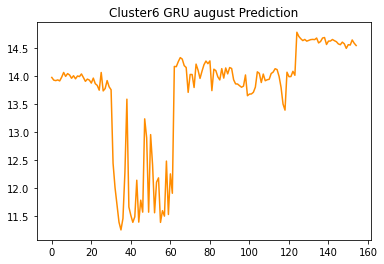

In [ ]:
plt.title('Cluster6 GRU august Prediction')
pd.Series(submit_pred6.reshape(155)).plot(color = 'darkorange', label='test')

In [ ]:
my_GRU_model6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 76, 50)            7950      
_________________________________________________________________
gru_7 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


## LSTM modeling

In [ ]:
def LSTM_model(X_train_t, y_train, submit_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train_t.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=1))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mae',metrics='mae')
    filepath="model/best_model.tf"
    mc = ModelCheckpoint(filepath, monitor='mae', save_best_only=True,)
    es = EarlyStopping(monitor='mae',patience=5)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train_t, y_train, epochs = 100, batch_size = 30,  verbose = 0,
                      callbacks=es)
    
    LSTM_prediction = my_LSTM_model.predict(submit_test)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
my_LSTM_model6, LSTM_prediction6 = LSTM_model(X_train_t6, y_train6, august6)
lstm_submit_pred6= scaler.inverse_transform(LSTM_prediction6)

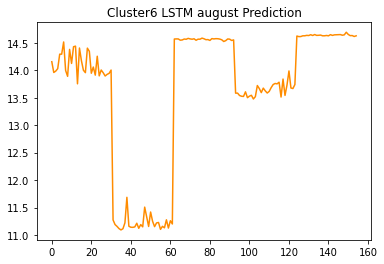

In [ ]:
plt.title('Cluster6 LSTM august Prediction')
pd.Series(lstm_submit_pred6.reshape(155)).plot(color = 'darkorange', label='test')

In [ ]:
my_LSTM_model6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 76, 50)            10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#6번 군집에 대한 GRU, LSTM 기하평균
augustgm6 = (pd.DataFrame(submit_pred6) * pd.DataFrame(lstm_submit_pred6))**(1/2)
augustgm6_list = list(np.array(augustgm6[0].tolist()))

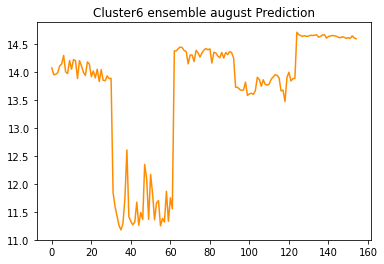

In [ ]:
plt.title('Cluster6 ensemble august Prediction')
plt.plot(augustgm6, color = 'darkorange', label='test')

## 8월 최종 예측

In [ ]:
g0 =list(submit_pred0.reshape(434))
g1=list(submit_pred1.reshape(62))
g2=list(submit_pred2.reshape(155))
g3=list(submit_pred3.reshape(372))
g4=list(submit_pred4.reshape(62))
g5=list(submit_pred5.reshape(62))
g6=augustgm6_list

In [ ]:
august_predict = {"d0":g0, "d1": g1, 'd2': g2, "d3":g3, "d4":g4, "d5":g5, "d6": g6}
august_predict_all = pd.DataFrame.from_dict(august_predict, orient='index').transpose()
august_predict_all.to_csv('deep_08_predict.csv', index=False)